

# Project: Comparison of Existing Algorithms applied on Flappy Bird

<a href="https://github.com/lplacidet/evolution_project">https://github.com/lplacidet/evolution_project</a>

Importing Libraries

In [1]:
using Random
using LinearAlgebra
using Statistics
using Plots

using Cxx, Libdl

gr(reuse=true)

Plots.GRBackend()

In [2]:
const path_to_lib = pwd()
addHeaderDir(path_to_lib*"/world/", kind=C_System)
cxxinclude("runWorld.h")
print("gg")
#objective = @cxx FlappyXP->evaluate
print("re-gg")

ggre-gg

In [3]:
mutable struct Individu
    genes::Array{Float64}
    fitness::Float64
end

function Individu(n::Int)
    newgenes = [0.0,0.0,0.0,0.0]
    for i in 1:4
        newgenes[i] = rand()
    end
    Individu(newgenes, -Inf)
end 

Individu

In [4]:
cxx"""

static double evaluate_bird(float g1, float g2, float g3, float g4) {
float ind[4] = {g1,g2,g3,g4};
bool dbg = false;
#ifdef DISPLAY
	initscr();
	timeout(0);
	noecho();
	curs_set(FALSE);
#endif
	const int NRUN = 3;
	auto &g = ind;
	double d = 0;
	for (int r = 0; r < NRUN; ++r) {
		World world;
		world.gen.seed(r * 100);
		while (world.bestiau.vivant) {
#ifdef DISPLAY
            std::this_thread::sleep_for(std::chrono::milliseconds(25));
            display(world, world.dist == 0);
#endif
            world.update();
            // update inputs
            float birdY = world.bestiau.y;
            float birdVY = world.bestiau.vit;
            float obsX;
            float obsY;
            if (world.obstacles.size() > 0) {
                const auto &o = world.obstacles.front();
                obsY = o.y + world.hauteurPassage * 0.5;
                obsX = o.x / world.W;
            } else {
                obsY = world.H * 0.5;
                obsX = 1000.0;
            }
            //if ((g[0]*birdY+g[1]*birdVY+g[2]*obsX+g[3]*obsY)>1.0) world.bestiauUp();
            if ((g[0]*(birdY-obsY)+g[1]*birdY+g[2]*obsX+g[3]*birdVY)>1.0) world.bestiauUp();
        }
        d += world.dist;
        d += 0.01*abs(world.bestiau.y-world.obstacles.front().y);
    }
#ifdef DISPLAY
    endwin();
#endif
    return d;
}
"""

true

In [5]:
cpptojulia(g1::Float64, g2::Float64, g3::Float64, g4::Float64) = @cxx evaluate_bird(g1,g2,g3,g4)

cpptojulia (generic function with 1 method)

In [6]:
function evaluate_bird(g::Array{Float64})
    cpptojulia(g[1],g[2],g[3],g[4])
end

evaluate_bird (generic function with 1 method)

In [ ]:
test_ind = Individu(4)
println(test_ind)
cpptojulia(test_ind.genes[1], test_ind.genes[2],test_ind.genes[3], test_ind.genes[4])



## I. CMA-ES Algorithm


In [ ]:
solution = [3.5, -0.2]
sphere(x::Array{Float64}) = sum((x .- solution).^2)
himmelblau(x::Array{Float64}) = (x[1]^2 + x[2] - 11)^2 + (x[1] + x[2]^2 - 7)^2
styblinski_tang(x::Array{Float64}) = sum(x.^4 .- 16 .* x.^2 .+ 5 .* x) / 2.0
rastrigin(x::Array{Float64}) = 10.0 * length(x) .+ sum((x .- solution).^2 .- 10 .* cos.(2*pi.*(x .- solution)))

In [ ]:
mutable struct CMAES
    N::Int
    μ::Int
    λ::Int
    τ::Float64
    τ_c::Float64
    τ_σ::Float64
    population::Array{Array{Float64}}
    offspring::Array{Array{Float64}}
    F_μ::Array{Float64}
    F_λ::Array{Float64}
    C::Array{Float64}
    s::Array{Float64}
    s_σ::Array{Float64}
    σ::Float64
    E::Array{Float64}
    W::Array{Float64}
    x::Array{Float64}
end

In [ ]:
N_value = 4
mu = 5
lambda = 150
objective = evaluate_bird

In [ ]:
function CMAES(;N=N_value, μ=mu, λ=lambda, τ=sqrt(N), τ_c=N^2, τ_σ=sqrt(N))
    x = randn(N)
    population = fill(x, µ)
    offspring = Array{Array{Float64}}(undef, λ)
    F_µ = Inf .* ones(µ)
    F_λ = Inf .* ones(λ)
    C = Array(Diagonal{Float64}(I, N))
    s = zeros(N)
    s_σ = zeros(N)
    σ = 1.0
    E = zeros(N, λ)
    W = zeros(N, λ);
    CMAES(N, μ, λ, τ, τ_c, τ_σ, population, offspring, F_µ, F_λ, C, s, s_σ, σ, E, W, x)
end

In [ ]:
c = CMAES()

In [ ]:
function step_cmaes!(c::CMAES; obj=objective, visualize=false, anim=Nothing)
    # L1
    sqrt_c = cholesky((c.C + c.C') / 2.0).U
    for i in 1:c.λ
        c.E[:,i] = randn(c.N)
        c.W[:,i] = c.σ * (sqrt_c * c.E[:,i])
        c.offspring[i] = c.x + c.W[:,i]
        c.F_λ[i] =  obj(c.offspring[i])
    end    
    # Select new parent population
    idx = sortperm(c.F_λ)[1:c.μ]
    for i in 1:c.μ
        c.population[i] = c.offspring[idx[i]]
        c.F_μ[i] = c.F_λ[idx[i]]
    end    
    # L2
    w = vec(mean(c.W[:,idx], dims=2))
    c.x += w    
    # L3
    c.s = (1.0 - 1.0/c.τ)*c.s + (sqrt(c.μ/c.τ * (2.0 - 1.0/c.τ))/c.σ)*w   
    # L4
    c.C = (1.0 - 1.0/c.τ_c).*c.C + (c.s./c.τ_c)*c.s'    
    # L5
    ɛ = vec(mean(c.E[:,idx], dims=2))
    c.s_σ = (1.0 - 1.0/c.τ_σ)*c.s_σ + sqrt(c.μ/c.τ_σ*(2.0 - 1.0/c.τ_σ))*ɛ    
    # L6
    c.σ = c.σ*exp(((c.s_σ'*c.s_σ)[1] - c.N)/(2*c.N*sqrt(c.N)))
    if visualize
        plot(xs, ys, fz, st=:contour)
        scatter!([c.offspring[i][1] for i in 1:λ], [c.offspring[i][2] for i in 1:λ], 
            xlims=(-5, 5), ylims=(-5, 5), legend=:none)
        scatter!([c.x[1]], [c.x[2]], color=:black, marker=:rect,
            xlims=(-5, 5), ylims=(-5, 5), legend=:none)
        frame(anim)
    end
    c
end



In [ ]:
c = CMAES()
println(c.population[1])
step_cmaes!(c)
println(c.population[1])
step_cmaes!(c)
println(c.population[1])

In [ ]:
function plot_obj_cmaes()
    c = CMAES()
    println("x initial: ", c.x)
    anim = Animation()
    for i in 1:100
        v = mod(i, 1) == 0
        step_cmaes!(c, visualize=v, anim=anim)
    end
    println("x final: ", c.x)
    gif(anim)
end

In [ ]:
function not_plot_obj_cmaes(nbgen::Int)
    c = CMAES()
    for i in 1:nbgen
        v = mod(i, 1) == 0
        step_cmaes!(c, visualize=false)
        if i%100==0
            
    end
    c.x
end

In [ ]:
xs = -5.0:0.1:5.0
ys = -5.0:0.1:5.0

fz(x, y) = objective([x, y])
my_guess = not_plot_obj_cmaes(1000)
println(evaluate_bird(my_guess))
my_guess



## II. ES (mu/signam, lambda)


In [ ]:
s = [3.5, -0.2]
sphere(x::Array{Float64}) = -sum((x .- s).^2)


In [ ]:
npop = 50     # population size
sigma = 0.1   # noise standard deviation
alpha = 0.001 # step size
x = randn(2)  # initial expert

In [ ]:
xs = -5.0:0.1:5.0
ys = -5.0:0.1:5.0
#fz(x, y) = objective([x, y]);

function step_es(x::Array{Float64}; npop=50, sigma=0.1, alpha=0.01, visualize=false, anim=Nothing)
    N = randn(npop, 2)
    P = repeat(x, 1, npop)' .+ sigma .* N
    R = zeros(npop)
    for i in eachindex(R)
        R[i] = objective(P[i, :]) #evaluation
    end
    A = (R .- mean(R)) ./ std(R) #the selection is done here: we are giving a higher porbability to individuals that did well
    
    if visualize
        plot(xs, ys, fz, st=:contour)
        scatter!(P[:, 1], P[:, 2], xlims=(-5, 5), ylims=(-5, 5), zcolor=R)
        scatter!([x[1]], [x[2]], legend=:none, color=:black, marker=:rect)
        frame(anim)
    end
    
    x .+ alpha/(npop * sigma) .* [dot(N[:, i], A) for i in 1:size(N, 2)] #modification step: changing the center of gravity
end

In [ ]:
test_array = randn(4)
println(test_array)
norm1 = norm.(test_array)
norm2 = norm(test_array)
#norm3 = vecnorm.(test_array)
#norm4 = vecnorm(test_array)
println(norm1)
println(norm2)
#println(norm3)
#println(norm4)

println(1.0/0.0)
println(isinf(1.0/0.0))

In [7]:
function step_birds(best::Array{Float64};dim=4, npop=50, sigma=0.01, alpha=sigma/10)
    N = randn(npop,dim)
    P = repeat(best, 1, npop)' .+ sigma .* N
    """
    println("P avant :",P)
    for i in eachindex(P[:,1])
        P[i,:] = P[i,:]./norm(P[i,:])
        if isinf(norm(P[i,:]))
            println("whola j'suis bloque")
        end
    end
    println("P apres :",P)
    """
    R = zeros(npop)
    for i in eachindex(R)
        R[i] = objective(P[i, :]) #evaluation
    end
    
    
    #println("  R    :", R)
    
    A = (R .- mean(R)) ./ std(R)
    #println("____________________")
    #println(" A :", A)
    #println("____________________")
    #println(" N : ", N[:,1])
    
    test = dot(N[:, 1], A)
    #println(" test :", test)
    if isnan(test)
        println("failed")
    end
    mat = [dot(N[:, i], A) for i in 1:size(N, 2)]
    #println("mat : ", mat)
    #println(alpha/(npop * sigma) .* mat)
    w = alpha/(npop * sigma) .* mat#[dot(N[:, i], A) for i in 1:size(N, dim)]
    #println(" w : ", w)
    best = best .+ w #modification step: changing the center of gravity
    best#./norm(best)
end

    

step_birds (generic function with 1 method)

In [8]:
function run_es_bird(;Nstep=500, Npop=100, Sigma=0.1)
    dim = 4
    best = randn(dim)
    best = best./norm(best)
    println("best initial: ", best)
    dist = zeros(Nstep)
    for i in 1:Nstep
        best = step_birds(best, dim=dim, npop=Npop, sigma=Sigma)
        #println("best: ", best)
        #println("best norm: ", norm(best))
        #println("dist max :" , objective(best))
        dist[i] = objective(best)
        #if dist[i]>300
         #   Sigma = 0.01
        #end
    end
    println("best final: ", best)
    println("best final dist: ", objective(best))
    #best
    dist
end


run_es_bird (generic function with 1 method)

best initial: [0.13272248948676033, -0.8352890302206623, 0.15801662400179187, -0.5096152699012646]
best final: [-3.7213305024199714, -0.4641835291198645, -0.22766461888475142, -1.9079812858916654]
best final dist: 330.2703473549643


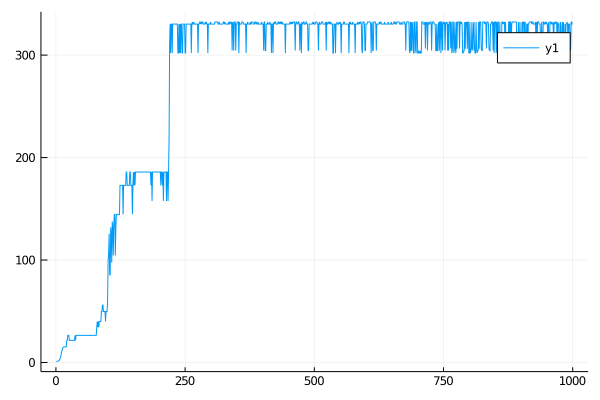

In [22]:
objective = evaluate_bird
Npop = 20
Ngen = 1000
sig = 0.1
res = run_es_bird(Nstep=Ngen, Npop=Npop, Sigma=sig)
#best_bird = res
distances = res
#println(best_bird)
#dist = evaluate_bird(best_bird)
#println(dist)
plot(distances)

In [ ]:
function plot_obj_es()
    x = randn(2) #initial population: which is a single point
    println("x initial: ", x)
    anim = Animation()
    for i in 1:500
        v = mod(i, 10) == 0
        x = step_es(x, npop=50, sigma=0.1, alpha=0.001, visualize=v, anim=anim)
    end
    println("x final: ", x)
    gif(anim)
end

In [ ]:
xs = -5.0:0.1:5.0
ys = -5.0:0.1:5.0

#fz(x, y) = objective_es([x, y])
println(solution) # optimal for sphere and rastrigin
#plot_obj_cmaes()